In [1]:
import os
!ls
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('/content/Mask_RCNN/')
!pwd

mask_rcnn_coco.h5  sample_data
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.84 MiB | 44.82 MiB/s, done.
Resolving deltas: 100% (570/570), done.
/content/Mask_RCNN


In [2]:
!python3 setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn

In [3]:
!git clone https://github.com/aithaytham/image

Cloning into 'image'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 56 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (56/56), done.


In [4]:
!git clone https://github.com/scikit-image/scikit-image

Cloning into 'scikit-image'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 71121 (delta 0), reused 3 (delta 0), pack-reused 71116
Receiving objects: 100% (71121/71121), 60.16 MiB | 30.48 MiB/s, done.
Resolving deltas: 100% (52399/52399), done.


In [0]:
#importer l'ensembles des librairies dont on nous avons besoin
import json

from PIL import Image

from os import listdir

from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.utils import Dataset

from mrcnn.config import Config

from mrcnn.model import mold_image
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt

from mrcnn.visualize import display_instances

import skimage

from matplotlib import pyplot

import random

In [0]:
#la sortie de la fonction tableau_information : deux listes img_id et coordonnes

#exemples:

# img_id = ['img1','img2',...,'img101'] 


# coordonnees = [[{'shape_attributes': {'name': 'polyline', 
#'all_points_x': [55, 76, 92, 102, 101, 84, 73, 59, 57],
#    'all_points_y': [40, 55, 55, 57, 41, 41, 37, 36, 44]},
#   'region_attributes': {}},
#  {'shape_attributes': {'name': 'polyline',
#    'all_points_x': [155, 174, 185, 186, 149, 147, 161],
#    'all_points_y': [66, 61, 64, 53, 48, 52, 66]},
#   'region_attributes': {}}],
# [{'shape_attributes': {'name': 'polyline',
#    'all_points_x': [315, 333, 351, 368, 368, 353, 331, 321, 319],
#    'all_points_y': [103, 113, 114, 110, 99, 100, 98, 96, 104]},
#   'region_attributes': {}}]] 


def tableau_information():
    with open ('/content/Mask_RCNN/image/ImageJSON2.json') as json_data:
        a=json.load(json_data)
        img_id=[]
        coordonnees=[]
        for i in range(len(list(a.values()))):
            img_id.append(list(a.values())[i]["filename"])
            coordonnees.append(list(a.values())[i]["regions"])
        
        return img_id, coordonnees

#le tableau d est le tableau que nous allons utiliser en fonction de notre fichier JSON 
d=tableau_information()[0]

# la list train est la liste random des 80 images que nous allons utiliser pour la partie train
list_train = random.sample(range(1,len(d)+1), int(0.2*len(d)+1))
#la sortie de la fonction information : une liste 

#exemple:

# list_train = [[[[[122, 124, 134, 140, 146, 151, 155, 166, 169, 169, 155, 144, 133, 123, 123], [64, 73, 73, 69, 62, 65, 69, 69, 61, 56, 56, 59, 60, 61, 66]]], 299, 168]

# list_train = [[[[["all_points_x"], ["all_points_y"]]], w, h]
    
      
def information (img_name, donnees):
    with open ('/content/Mask_RCNN/image/ImageJSON2.json') as json_data:
        a=json.load(json_data)
        ind = donnees.index(img_name + '.jpg')
        
        nbr_boxes=len(list(a.values())[ind]["regions"])
        list_info=[[]] 
        
        for j in range(nbr_boxes):  
            x=(list(a.values())[ind]["regions"][str(j)]["shape_attributes"]["all_points_x"])
            
            y=(list(a.values())[ind]["regions"][str(j)]["shape_attributes"]["all_points_y"])
            list_info[0].append([x,y])
           
        im=Image.open("/content/Mask_RCNN/image/image2/"+img_name+".jpg")
        list_info.append(im.size[0])
        list_info.append(im.size[1])
      
        return list_info

In [9]:
#class that defines and loads the glasses dataset
class HandleDoorDataset(Dataset):

  # load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
    # define one class
    self.add_class("dataset", 1, "image")
    # define data locations
    images_dir = dataset_dir + '/image2/'
    annotations_dir = dataset_dir + '/ImageJSON2.json/'
    # find all images
    for filename in listdir(images_dir):
      # extract image id
      image_name = filename[:-4]
      image_id = filename[3:-4]      
      # skip all images after 33 if we are building the train set
      if is_train and int(image_id) in list_train:
        continue
		  # skip all images before 33 if we are building the test/val set
      if not is_train and not int(image_id) in list_train :
        continue
      img_path = images_dir + filename
      ann = information(image_name,d)
      # add to dataset
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann)


  def load_mask(self, image_id):
    info = self.image_info[image_id]
    # define box file location
    path = info['annotation']
    # load JSON
    boxes=path[0] 
    w=path[1]   
    h=path[2] 
    #boxes, w, h = self.extract_boxes(path)
    # create one array for all masks, each on a different channel
    masks = zeros([h, w, len(boxes)], dtype='uint8')
    # create masks
    class_ids = list()
    for i in range(len(boxes)):
      box = boxes[i]      
      rr, cc = skimage.draw.polygon(box[1], box[0])
      masks[rr, cc, i] = 1
      class_ids.append(self.class_names.index('image'))
    return masks, asarray(class_ids, dtype='int32')


  def image_reference(self, image_id):
   info = self.image_info[image_id]
   return info['path']


# train set
train_set = HandleDoorDataset()
train_set.load_dataset('image', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 

# test/val set
test_set = HandleDoorDataset()
test_set.load_dataset('image', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 37
Test: 10


In [10]:
# define a configuration for the model
class HandleDoorConfig(Config):
	# define the name of the configuration
	NAME = "image_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = len(train_set.image_ids)   #80


# prepare config
config = HandleDoorConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
37/37 [==============================] - 93s 3s/step - loss: 2.3983 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.3515 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.7918 - mrcnn_mask_loss: 1.0993 - val_loss: 2.0513 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 0.4994 - val_mrcnn_class_loss: 0.0350 - val_mrcnn_bbox_loss: 0.9377 - val_mrcnn_mask_loss: 0.5691

Epoch 2/5
37/37 [==============================] - 35s 958ms/step - loss: 1.6229 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.3541 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.7393 - mrcnn_mask_loss: 0.4779 - val_loss: 1.5216 - val_rpn_class_loss: 0.0079 - val_rpn_bbox_loss: 0.3746 - val_mrcnn_class_loss: 0.0313 - val_mrcnn_bbox_loss: 0.6803 - val_mrcnn_mask_loss: 0.4274
Epoch 3/5
37/37 [==============================] - 36s 963ms/step - loss: 1.3806 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2047 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.7881 - mrcnn_mask_loss: 0.3383 - val_loss: 1.7495 - val_rpn_class_loss

In [0]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "image_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1


# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP


# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('mask_rcnn_image_cfg_0005.h5', by_name=True)


(1280, 852, 1)
(1280, 852, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(640, 640, 1)
(640, 640, 2)
(856, 1280, 1)
(856, 1280, 7)
(2132, 3112, 1)
(2132, 3112, 7)
(3713, 2555, 1)
(3713, 2555, 7)


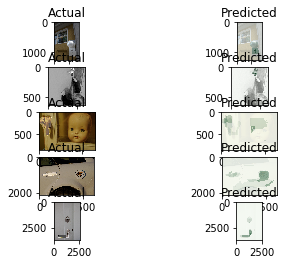

(853, 1280, 1)
(853, 1280, 2)
(645, 456, 1)
(645, 456, 2)
(683, 1024, 1)
(683, 1024, 3)
(3456, 5184, 1)
(3456, 5184, 15)
(2304, 3072, 1)
(2304, 3072, 6)


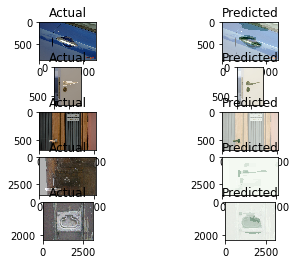

<Figure size 432x288 with 0 Axes>

In [14]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
  # load image and mask
  for i in range(n_images):
    # load the image and mask
    image = dataset.load_image(i)
    mask, _ = dataset.load_mask(i)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]
  
    # define subplot
    pyplot.subplot(n_images, 2, i*2+1)
    # plot raw pixel data
    pyplot.imshow(image)
    pyplot.title('Actual')
    # plot masks
    print(mask.shape)
    for j in range(mask.shape[2]):
      pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
    # get the context for drawing boxes
      pyplot.subplot(n_images, 2, i*2+2)
    # plot raw pixel data
    pyplot.imshow(image)
    
    pyplot.title('Predicted')
    ax = pyplot.gca()
    



    # plot yhat
    print(yhat['masks'].shape)
    for j in range(yhat['masks'].shape[2]):
      pyplot.imshow(yhat['masks'][:, :, j], cmap='Greens', alpha=0.3)
    # get the context for drawing boxes
      pyplot.subplot(n_images, 2, i*2+2)
    # plot raw pixel data


  # show the figure
  pyplot.show()
  pyplot.savefig('resultat.png')

# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)

# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)